In [1]:
import os
import os.path as op
import json
import cv2
import base64
import random
import numpy as np
from tqdm import tqdm
from textwrap import wrap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image, ImageDraw

from maskrcnn_benchmark.structures.tsv_file import TSVFile

In [2]:
#json_root = '/media/stopmosk/data/huawei/datasets_orig/BIG'
orig_root = '/mnt/Toshiba2TB/dataset_ImageCaption'
rules_root = orig_root


# exp_root = '../../../../datasets_proc/big_nn_nms1'

In [3]:
img_paths = dict()

folder_list = [f for f in os.listdir(orig_root) if '.' not in f]

for folder in folder_list[:5]:
    print(folder, flush=True)
    img_list = [f for f in os.listdir(op.join(orig_root, folder))]
    for img_filename in tqdm(img_list):
        img_paths[img_filename] = op.join(orig_root, folder, img_filename)


CC_DATASET1


100%|██████████| 449055/449055 [00:00<00:00, 863435.51it/s]

CC_DATASET2



100%|██████████| 436727/436727 [00:00<00:00, 815534.26it/s]

CC_DATASET3



100%|██████████| 369671/369671 [00:00<00:00, 822951.24it/s]

CC_DATASET4



100%|██████████| 385483/385483 [00:00<00:00, 745594.51it/s]

CC_val



100%|██████████| 9988/9988 [00:00<00:00, 768758.18it/s]


In [4]:
# sample
img_paths[list(img_paths.keys())[0]]

'/mnt/Toshiba2TB/dataset_ImageCaption/CC_DATASET1/0000006ee283bee151d361963b2907c1.jpg'

In [5]:
with open(op.join(orig_root, 'Final_EN.json')) as f:
#with open(op.join(orig_root, 'cc_caps_filtered.json')) as f:
    dataset_captions = json.load(f)

dataset_captions = dataset_captions['annotations']
len(dataset_captions)

2620065

In [6]:
dataset_captions[0]

{'file_name': 'a1650e00b6261e99a6bbe6fe13919302.jpg',
 'caption': 'author : a life in photography -- in pictures',
 'category_id': -1}

In [8]:
sorted_caps = sorted(dataset_captions, key=lambda x: x['caption'])

only_captions = [s['caption'] for s in dataset_captions]
only_captions.sort()
only_captions[120000]

# with open('../../../../caps.txt', 'w') as fp:
#     for cap in only_captions:
#         fp.write(cap + '\n')

' Chefs standing in front of their food .'

In [9]:
# Remove keys from sorted_caps
print(len(sorted_caps))
sorted_caps = [s for s in sorted_caps if s['file_name'] in img_paths]
print(len(sorted_caps))

2620065
1548138


In [10]:
# Save JSON

with open(os.path.join(orig_root, f'cc_caps_EN.json'), 'w') as fp:
    json.dump({'annotations': sorted_caps}, fp)

640306


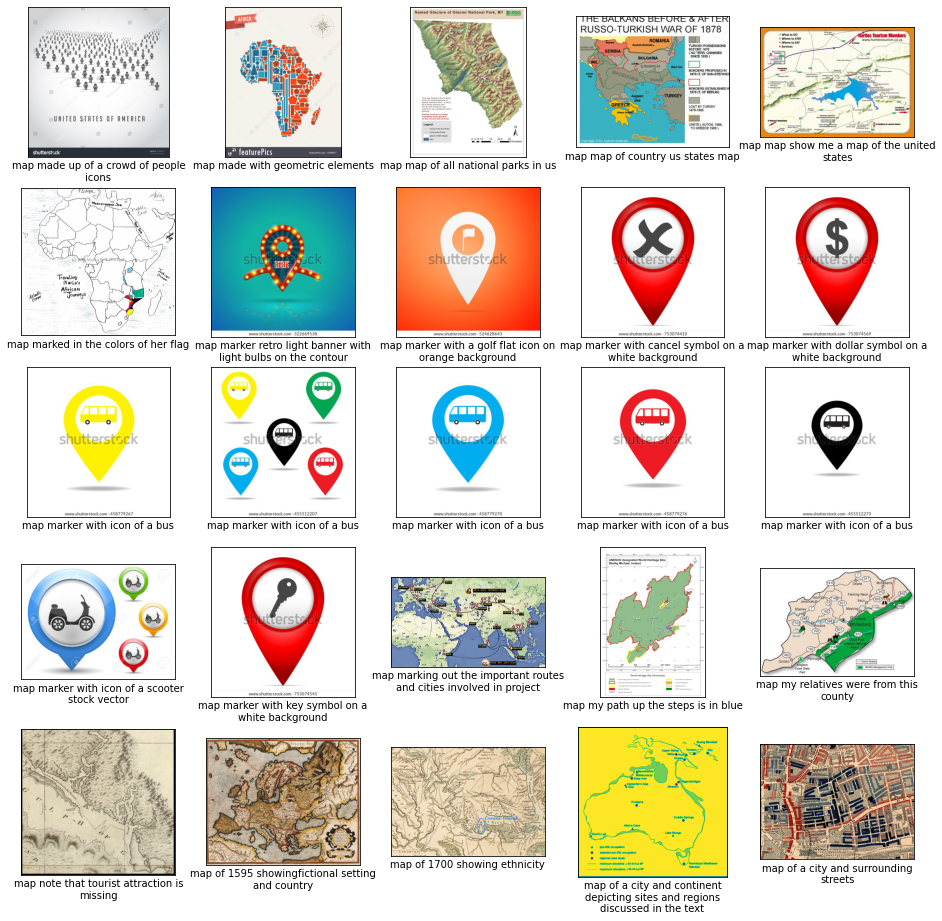

In [199]:
# Show sample images 

start_str, shift = 'map ', 1000

for i, s in enumerate(sorted_caps):
    if s['caption'].startswith(start_str):
        print(i)
        start_k = i
        break

plt.figure(figsize=(16, 16))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])    
    im = Image.open(img_paths[sorted_caps[start_k + shift + i]['file_name']])
    plt.imshow(im)
    plt.xlabel('\n'.join(wrap(sorted_caps[start_k + shift + i]['caption'], 36)))
plt.show()

In [200]:
START = 1
END = 2
ANY = 3
TOEND = 4  # Find first and replace to end  
# string "table -- stock photo..." with rule (TOEND, ' -- stock', '') gets "table"

# rules = [
#     (START, ' Chefs ', 'Dicks '),
#     (START, '22', None),
#     (TOEND, '- stock photo', '')
# ]

In [201]:
with open(os.path.join(rules_root, 'replace_new1.txt')) as fp:
    raw_rules = fp.read().splitlines() 

raw_rules[:5]

["a'the most'", "a'is one of the'", "a'in this undated file photo'"]

In [202]:
def parse_raw(raw_str):
    if raw_str == '':
        # print('Empty str')
        return None
    sub_s, rep_s, tmp_s = None, None, None
    rule_type = START

    i = 0
    is_text = False
    accum = ''
    while True:
        if i == len(raw_str):
            # some finish process
            if sub_s is None:
                sub_s = tmp_s
            else:
                rep_s = tmp_s            
            break

        c = raw_str[i]
        
        if is_text:
            if c == opener:
                is_text = False
                tmp_s = accum
                accum = ''
            else:
                accum += c
            i += 1
            continue

        # else we're in ctrl_mode
        if c == "'" or c == '"':
            opener = c
            is_text = True
        elif c == '-':
            if raw_str[i: i+3] != '-->':
                print('ERROR:', raw_str)
                exit
            sub_s = tmp_s
            i += 3            
            continue
        elif c == ' ':
            pass            
        elif c == 'e':
            rule_type = END
        elif c == 'a':
            rule_type = ANY            
        elif c == 't':
            rule_type = TOEND        
        elif c == '#':
            print('Comment:', raw_str[1:])
            return None
        else:
            print(raw_str, c)
            
        i += 1
            
    return rule_type, sub_s, rep_s

rules = []
for raw_rule in raw_rules:
    # print(raw_rule)
    parsed_rule = parse_raw(raw_rule)
    # print(raw_rule, '******', parsed_rule)
    if parsed_rule is not None:
        rules.append(parsed_rule)

In [203]:
rules[:20]

[(3, 'the most', None),
 (3, 'is one of the', None),
 (3, 'in this undated file photo', None)]

In [204]:
def apply_rules(caption, rules):
    # One by one apply rules, repeat until [del] or [same str (no changes)]
    curr_caption = caption
    while True:
        temp_caption = curr_caption

        for (where, sub_str, replace_str) in rules:
            if not ((where == START and curr_caption.startswith(sub_str))
                    or (where == END and curr_caption.endswith(sub_str)) 
                    or (where == ANY and sub_str in curr_caption)
                    or (where == TOEND and sub_str in curr_caption)):
                continue
                            
            # if we have to delete this caption
            if replace_str is None:
                    return None

            # else we should replace substring
            if where == START:
                curr_caption = curr_caption.replace(sub_str, replace_str, 1)
            elif where == END:
                c_len, s_len = len(curr_caption), len(sub_str)
                curr_caption = curr_caption[:c_len - s_len] + replace_str
            elif where == TOEND:
                curr_caption = curr_caption[0: curr_caption.find(sub_str)] + replace_str
            elif where == ANY:
                curr_caption = curr_caption.replace(sub_str, replace_str)
            else:
                raise RuntimeError('Unknown rule')
            
        if curr_caption == temp_caption:
            return curr_caption

filtered_caps = []

cnt = 0
for el in tqdm(sorted_caps):
    cap = el['caption']
    new_cap = apply_rules(cap, rules)
    if new_cap is None:
        cnt += 1
        continue
    new_el = el.copy()
    new_el['caption'] = new_cap
    if new_cap != cap:
        # print(cap, '*****', new_cap)
        cnt += 1
    filtered_caps.append(new_el)

print(f'Changed or deleted captions: {cnt}/{len(sorted_caps)}')

100%|██████████| 968634/968634 [00:00<00:00, 1084848.73it/s]

Changed or deleted captions: 1993/968634


In [205]:
sorted_caps = sorted(filtered_caps, key=lambda x: x['caption'])

In [206]:
# 1-0: Changed captions: 9207/1548138
# 2-0: Changed or deleted captions: 1486/1548138
# 3-0: Changed or deleted captions: 548921/1546658
# 4-0: Changed or deleted captions: 290042/1236569
# 1-1: Changed or deleted captions: 0/969557
# 2-1: Changed or deleted captions: 921/969557
# 3-1: Changed or deleted captions: 416/968747
# 4-1: Changed or deleted captions: 0/968705
#1993/968634

In [163]:
sorted_caps = sorted_caps[:-67]

In [207]:
sorted_caps[-10:]

[{'file_name': '9cb2b3118579241eae0ba98b0655f986.jpg',
  'caption': 'zooming pass a car at the high level bridge',
  'category_id': -1},
 {'file_name': 'f5d74e1b345d018fc3d11c83502407c7.jpg',
  'caption': 'zoot suit this style of clothing became popular within the african communities during the 1940s',
  'category_id': -1},
 {'file_name': '3111a4e353deb3aa1b1d6dcf66fe6e75.jpg',
  'caption': 'zouave statue serves as a measure of water level',
  'category_id': -1},
 {'file_name': 'e60d9da4ac2cdf47e43302dbcdca0fc0.jpg',
  'caption': 'zucchini and squash from the garden',
  'category_id': -1},
 {'file_name': '4ab093f1211b3c93a7de78f33a38d57a.jpg',
  'caption': 'zucchini is another name for which vegetable',
  'category_id': -1},
 {'file_name': '37a653299d4075000c773bb5a67e3a4d.jpg',
  'caption': 'zucchini on a wooden table',
  'category_id': -1},
 {'file_name': '1415e45ca1517a7b335ad0b52ab4cd9f.jpg',
  'caption': 'zucchini stuffed with cheese on a white plate',
  'category_id': -1},
 {'fil

In [208]:
# Save JSON

with open(os.path.join(orig_root, f'cc_caps_filtered_new.json'), 'w') as fp:
    json.dump({'annotations': sorted_caps}, fp)

In [209]:
only_captions_2 = [s['caption'] for s in sorted_caps]
only_captions_2.sort()
only_captions_2[120000]

'a player of the swings and pops a fly ball'

In [210]:
with open('../../../../caps_improved_new.txt', 'w') as fp:
    for cap in only_captions_2:
        fp.write(cap + '\n')

In [211]:
dataset_dir = '/mnt/ssd/cc_vvl_nms1'
splits = ['train', 'val', 'test']

ds_caps = {split: [] for split in splits}
for split in tqdm(splits):
    with open(os.path.join(dataset_dir, f'{split}_caption.json')) as fp:
        ds_caps[split] = json.load(fp)


100%|██████████| 3/3 [00:00<00:00,  4.54it/s]


In [212]:
ds_caps['test'][0]

{'image_id': '8d71c508fc505357f78ebd7653edc54f',
 'id': 788901,
 'caption': 'an aerial view of the campus'}

In [213]:
sorted_caps_by_filename = {s['file_name'].split('.')[0]: s['caption'] for s in sorted_caps}
        
list(sorted_caps_by_filename.keys())[:2], sorted_caps_by_filename['54fc935940ad185f5babad2fb0ab8807']

(['54fc935940ad185f5babad2fb0ab8807', '468c50c89745487523651035f27b840c'],
 "'s actually and old drawing")

In [214]:
out_captions = {split: [] for split in splits}

for split in tqdm(splits):
    for s in ds_caps[split]:
        if s['image_id'] in sorted_caps_by_filename.keys():
            s['caption'] = sorted_caps_by_filename[s['image_id']]
            out_captions[split].append(s)

out_captions['val'][0]

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


{'image_id': '0206f96a8c046037e08b659016e7fc2f',
 'id': 465166,
 'caption': 'a model walks the runway at the fashion show during event'}

In [215]:
exp_root = dataset_dir

for split in tqdm(splits):
    
    # Generate captions in COCO format

    idim = []
    for cap in out_captions[split]:
        idim.append({'id': cap['image_id'], 'file_name': cap['image_id']})

    out_captions_coco_fmt = {'annotations': out_captions[split], 'images': idim, 'type': 'captions', 'info': 'dummy', 'licenses': 'dummy'}

    # Save JSON

    with open(os.path.join(exp_root, f'{split}_caption.json'), 'w') as fp:
        json.dump(out_captions[split], fp)

    with open(os.path.join(exp_root, f'{split}_caption_coco_format.json'), 'w') as f:
        json.dump(out_captions_coco_fmt, f)

out_captions['val'][:3]

100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


[{'image_id': '0206f96a8c046037e08b659016e7fc2f',
  'id': 465166,
  'caption': 'a model walks the runway at the fashion show during event'},
 {'image_id': '2471cb9b0587400bdbc59d6d77a50e92',
  'id': 1222315,
  'caption': 'football player shouts to his players during the quarter final first leg match'},
 {'image_id': 'e5e74a5b5b4e7ea6bf444e4035b2783a',
  'id': 621677,
  'caption': 'skyline catches the evening light as seen'}]